# Comparison between spectral and classical approach to regression

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from Spectral_Layer import Spectral
#from pytorch_lightning.callbacks import EarlyStopping

## Generate dataset 
Here is generated a test dataset of the form $x^{\alpha}$ on which is added some noise taken from a gaussian distribution   

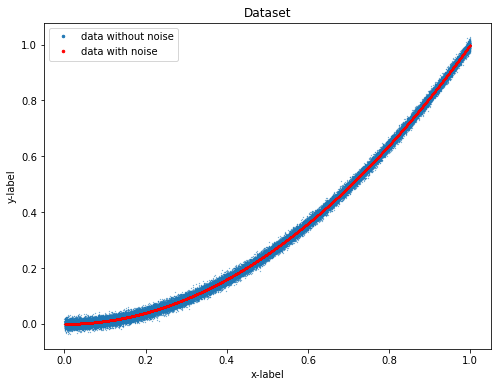

In [2]:
alpha = 2. 
sigma = 0.01
size = 70000

x = np.linspace(0, 1, size)
z = np.random.normal(0, sigma, size)  # noise
t = x**alpha
y = t + z   # add noise

X = []
Y = []
for i in range(size):
    X.append([x[i]])
    Y.append([y[i]])
    
X = np.array(X)
Y = np.array(Y)

plt.figure (figsize = (8, 6))
plt.plot(X, Y, marker='.', linestyle = '', label='data without noise', markersize=0.5)
plt.plot(x, t, marker='.', linestyle='', color='red', label='data with noise', markersize=0.5)
plt.title('Dataset')
plt.legend(markerscale=10.)
plt.xlabel('x-label')
plt.ylabel('y-label')
plt.show()

In [3]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

X = torch.from_numpy(X)
Y = torch.from_numpy(Y)

# Define dataset
dataset = TensorDataset(X, Y)
train_ds, val_ds, test_ds = random_split(dataset, [50000, 10000, 10000])

# Define data loader
batch_size = 1500
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size)
test_dl = DataLoader(test_ds, batch_size)

## Classical model

In [4]:
# Classical regressio model
args = {'bias': False,
       'dtype': torch.double}



class ClassicalModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linearin = nn.Linear(1, 20, **args)
        self.linearhid = nn.Linear(20, 20, **args)
        self.linearout = nn.Linear(20, 1, **args)
    
    def forward(self,x):
        out = self.linearin(x)  # Imput: first linear transformation
        out = self.linearhid(out) # Linear transformatiion
        out = F.elu(out)   # Non lienar filter
        out = self.linearhid(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.linearout(out)  # Last linear transformation: output
        return out
    
    def training_step(self, batch):
        x, y = batch 
        out = self(x)                  # Generate predictions
        loss = F.mse_loss(out, y) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        x, y= batch 
        out = self(x)                    # Generate predictions
        loss = F.mse_loss(out, y)   # Calculate loss
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.6f}".format(epoch, result['val_loss']))

classical_model = ClassicalModel()

In [5]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    #es = EarlyStopping(patience=5) # stop with patience 5
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
        # Early stopping
        #if es.step(loss):
        #        break  

    return history

In [6]:
args = {'lr': 0.01,
       'model': classical_model,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history_classical = fit(20, **args)

Epoch [0], val_loss: 0.015938
Epoch [1], val_loss: 0.013192
Epoch [2], val_loss: 0.005763
Epoch [3], val_loss: 0.000645
Epoch [4], val_loss: 0.000560
Epoch [5], val_loss: 0.000481
Epoch [6], val_loss: 0.000425
Epoch [7], val_loss: 0.000386
Epoch [8], val_loss: 0.000377
Epoch [9], val_loss: 0.000317
Epoch [10], val_loss: 0.000295
Epoch [11], val_loss: 0.000276
Epoch [12], val_loss: 0.000406
Epoch [13], val_loss: 0.000290
Epoch [14], val_loss: 0.000266
Epoch [15], val_loss: 0.000247
Epoch [16], val_loss: 0.000249
Epoch [17], val_loss: 0.000250
Epoch [18], val_loss: 0.000270
Epoch [19], val_loss: 0.000225


## Spectral model 

In [7]:
# Spectral Regression model with only train of eigenvalues
config = {'base_grad' : False,
         'start_grad' : True,
         'end_grad' : True,
         'bias': False}

class SpectralRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.spectralin = Spectral(1, 20, **config)
        self.spectral1 = Spectral(20, 20, **config)
        self.spectral2 = Spectral(20, 20, **config)
        self.spectralout = Spectral(20, 1, **config)
    
    def forward(self,x):
        out = self.spectralin(x)  # Imput: first linear transformation
        out = self.spectral1(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectral2(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectralout(out)  # Last linear transformation: output
        return out
    
    def training_step(self, batch):
        x, y = batch 
        out = self(x)                  # Generate predictions
        loss = F.mse_loss(out, y) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        x, y= batch 
        out = self(x)                    # Generate predictions
        loss = F.mse_loss(out, y)   # Calculate loss
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.6f}".format(epoch, result['val_loss']))
        
        
spectral_model_eigenvalue = SpectralRegression()

In [8]:
# Spectral Regression model with train of eigenvalues and eigenvectors
config = {'base_grad' : True,
         'start_grad' : True,
         'end_grad' : True,
         'bias': False}

class SpectralRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.spectralin = Spectral(1, 20, **config)
        self.spectral1 = Spectral(20, 20, **config)
        self.spectral2 = Spectral(20, 20, **config)
        self.spectralout = Spectral(20, 1, **config)
    
    def forward(self,x):
        out = self.spectralin(x)  # Imput: first linear transformation
        out = self.spectral1(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectral2(out) # Linear transformation
        out = F.elu(out)   # Non linear filter
        out = self.spectralout(out)  # Last linear transformation: output
        return out
    
    def training_step(self, batch):
        x, y = batch 
        out = self(x)                  # Generate predictions
        loss = F.mse_loss(out, y) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        x, y= batch 
        out = self(x)                    # Generate predictions
        loss = F.mse_loss(out, y)   # Calculate loss
        return {'val_loss': loss}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.6f}".format(epoch, result['val_loss']))
        
        
spectral_model_complete = SpectralRegression()

In [9]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    #es = EarlyStopping(patience=10)
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
        
        # Early stopping
        #if es.step(loss):
        #        break  

    return history

In [10]:
args = {'lr': 0.03,
       'model': spectral_model_eigenvalue,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history_spectral_eigenvalue = fit(20, **args)



Epoch [0], val_loss: 0.019433
Epoch [1], val_loss: 0.014501
Epoch [2], val_loss: 0.013678
Epoch [3], val_loss: 0.013095
Epoch [4], val_loss: 0.012837
Epoch [5], val_loss: 0.012532
Epoch [6], val_loss: 0.012162
Epoch [7], val_loss: 0.008995
Epoch [8], val_loss: 0.000468
Epoch [9], val_loss: 0.000242
Epoch [10], val_loss: 0.000240
Epoch [11], val_loss: 0.000226
Epoch [12], val_loss: 0.000220
Epoch [13], val_loss: 0.000243
Epoch [14], val_loss: 0.000210
Epoch [15], val_loss: 0.000347
Epoch [16], val_loss: 0.000262
Epoch [17], val_loss: 0.000192
Epoch [18], val_loss: 0.000190
Epoch [19], val_loss: 0.000252


In [11]:
args = {'lr': 0.03,
       'model': spectral_model_complete,
       'train_loader': train_dl,
       'val_loader': val_dl,
       'opt_func': torch.optim.Adam}

history_spectral_complete = fit(20, **args)



Epoch [0], val_loss: 0.017753
Epoch [1], val_loss: 0.014089
Epoch [2], val_loss: 0.007478
Epoch [3], val_loss: 0.001178
Epoch [4], val_loss: 0.000727
Epoch [5], val_loss: 0.000674
Epoch [6], val_loss: 0.000498
Epoch [7], val_loss: 0.000560
Epoch [8], val_loss: 0.000443
Epoch [9], val_loss: 0.000419
Epoch [10], val_loss: 0.000409
Epoch [11], val_loss: 0.000393
Epoch [12], val_loss: 0.000551
Epoch [13], val_loss: 0.000864
Epoch [14], val_loss: 0.000411
Epoch [15], val_loss: 0.000461
Epoch [16], val_loss: 0.000436
Epoch [17], val_loss: 0.002384
Epoch [18], val_loss: 0.000486
Epoch [19], val_loss: 0.000341


## Results: spectral vs classical regression

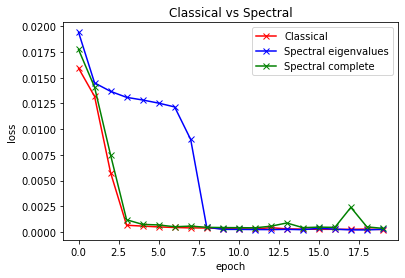

In [12]:
losses_classical = [result['val_loss'] for result in history_classical]
losses_spectral_eigenvalue = [result['val_loss'] for result in history_spectral_eigenvalue]
losses_spectral_complete = [result['val_loss'] for result in history_spectral_complete]
plt.plot(losses_classical, '-x', color='red', label='Classical' )
plt.plot(losses_spectral_eigenvalue, '-x', color='blue', label='Spectral eigenvalues')
plt.plot(losses_spectral_complete, '-x', color='green', label='Spectral complete' )
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Classical vs Spectral')
plt.legend()
plt.show()

In [13]:
ris_classical = evaluate(classical_model, test_dl)
ris_spectral_eigenvalue = evaluate(spectral_model_eigenvalue, test_dl)
ris_spectral_complete = evaluate(spectral_model_complete, test_dl)
print("Results obtained on the test dataset...")
print("Loss for classical model: {:.3} ".format(ris_classical['val_loss']))
print("Loss for spectral model trained on eigevalues: {:.3} ".format(ris_spectral_eigenvalue['val_loss']))
print("Loss for spectral model trained on eigenvalues and eigenvectors: {:.3} ".format(ris_spectral_complete['val_loss']))

Results obtained on the test dataset...
Loss for classical model: 0.000228 
Loss for spectral model trained on eigevalues: 0.00025 
Loss for spectral model trained on eigenvalues and eigenvectors: 0.000341 


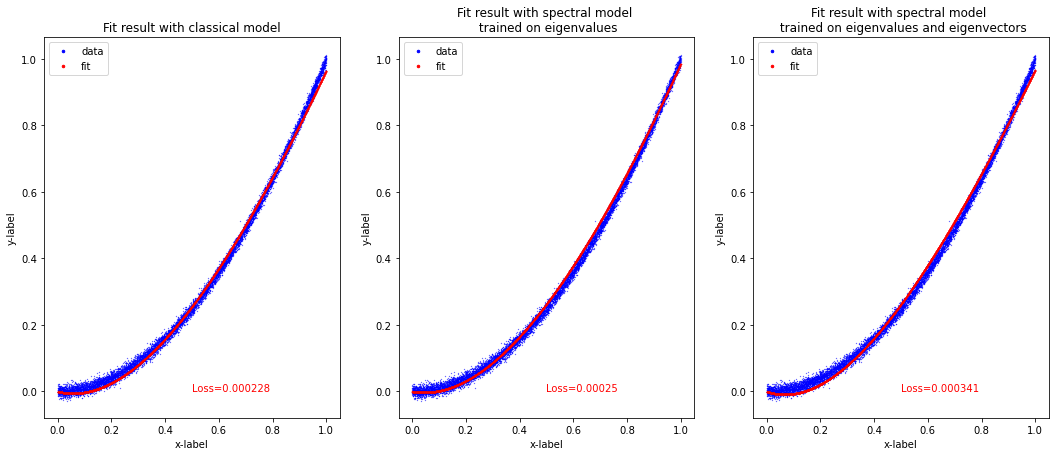

In [14]:
x_test, y_test = test_ds[:] 
y_classical = classical_model(x_test)
y_spectral_eigenvalue = spectral_model_eigenvalue(x_test)
y_spectral_complete = spectral_model_complete(x_test)
x_test = x_test.detach()
y_test = y_test.detach()
y_classical = y_classical.detach()
y_spectral_eigenvalue = y_spectral_eigenvalue.detach()
y_spectral_complete = y_spectral_complete.detach()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 7))

ax1.plot(x_test, y_test, color='blue', linestyle='', marker='.', label='data', markersize=0.5)
ax1.plot(x_test, y_classical, color='red', linestyle='', marker='.', label='fit', markersize=0.5)
ax1.set_title("Fit result with classical model")
ax1.set(xlabel='x-label', ylabel='y-label')
ax1.legend(markerscale=10.)
ax1.text(0.5, 0, 'Loss={:.3}'.format(ris_classical['val_loss']) , fontdict={'size': 10, 'color':  'red'})

ax2.plot(x_test, y_test, color='blue', linestyle='', marker='.', label='data', markersize=0.5)
ax2.plot(x_test, y_spectral_eigenvalue, color='red', linestyle='', marker='.', label='fit', markersize=0.5)
ax2.set_title("Fit result with spectral model \n trained on eigenvalues")
ax2.set(xlabel='x-label', ylabel='y-label')
ax2.legend(markerscale=10.)
ax2.text(0.5, 0, 'Loss={:.3}'.format(ris_spectral_eigenvalue['val_loss']) , fontdict={'size': 10, 'color':  'red'})

ax3.plot(x_test, y_test, color='blue', linestyle='', marker='.', label='data', markersize=0.5)
ax3.plot(x_test, y_spectral_complete, color='red', linestyle='', marker='.', label='fit', markersize=0.5)
ax3.set_title("Fit result with spectral model \n trained on eigenvalues and eigenvectors")
ax3.set(xlabel='x-label', ylabel='y-label')
ax3.legend(markerscale=10.)
ax3.text(0.5, 0, 'Loss={:.3}'.format(ris_spectral_complete['val_loss']) , fontdict={'size': 10, 'color':  'red'})

plt.show()